In [1]:
import torch
import torchvision
from torchvision.transforms import ToTensor
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np

/home/max/anaconda3/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_cuda.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
data_dir = ''

imgset = torchvision.datasets.MNIST(root=data_dir, train=True, download=False)

In [3]:
imgset

Dataset MNIST
    Number of datapoints: 60000
    Root location: 
    Split: Train

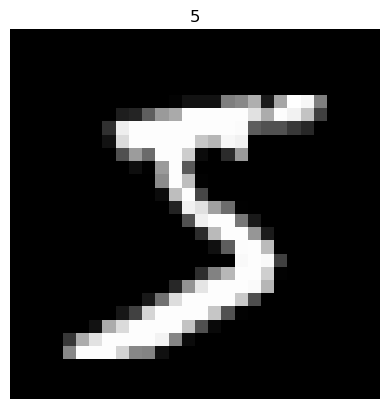

In [4]:
img, label = imgset[0]

plt.axis("off")
plt.title(label)
plt.imshow(img, cmap="gray")
plt.show()

In [5]:
transform = ToTensor()
image_tensor_dev = transform(img)

In [6]:
conv_layer = nn.Conv2d(1, 1, 3)
output = conv_layer(image_tensor_dev)

In [8]:
t4d = torch.empty(100, 32, 10, 10)
p1d = (1, 1, 1, 1) # pad last dim by 1 on each side
out = F.pad(t4d, p1d, "constant", 0)  # effectively zero padding
print(out.size())

torch.Size([100, 32, 12, 12])


In [9]:
def zero_pad(X, pad):
    """
    Pad with zeros all images of the dataset X. The padding is applied to the height and width of an image.
    
    Argument:
    X -- torch tensor of shape (m, n_C, n_H, n_W) representing a batch of m images.
        n_C, n_H, n_W denote respectively the number of channels, height and width 
    pad -- integer, amount of padding around each image on vertical and horizontal dimensions
    
    Returns:
    X_pad -- padded image of shape (m, n_C, n_H + 2 * pad, n_W + 2 * pad)
    """
    pad_per_dim = (pad, pad, pad, pad)
    X_pad = F.pad(X, pad_per_dim, "constant", 0) 
    
    return X_pad

In [11]:
out = zero_pad(t4d, 1)
print(out.size())

torch.Size([100, 32, 12, 12])


In [12]:
def conv_single_step(a_slice_prev, W, b):
    """
    Apply one filter defined by parameters W on a single slice (a_slice_prev).
    
    Arguments:
    a_slice_prev -- slice of input data of shape (f, f, n_C_prev)
    W -- Weight parameters contained in a window - matrix of shape (f, f, n_C_prev)
    b -- Bias parameter contained in a window - scalar value
    
    Returns:
    Z -- a scalar value, the result of convolving the sliding window (W, b) on a slice x of the input data
    """
    
    s = torch.mul(a_slice_prev, W)
    Z = torch.sum(s) + b

    return Z

In [13]:
a = torch.tensor([[1., -1.], [1., -1.]])
b = torch.tensor([[22., -10.], [1., 7.]])
torch.mul(a, b)

tensor([[22., 10.],
        [ 1., -7.]])

In [14]:
a_slice_prev = torch.tensor([[10, 9], [0, -1]])
W = torch.tensor([[0.5, 0.5], [0.1, -2]])
b = .001
conv_single_step(a_slice_prev, W, b)

tensor(11.5010)

In [15]:
a_slice_prev = torch.stack([a_slice_prev] * 3)
W = torch.stack([W] * 3)
b = .001
conv_single_step(a_slice_prev, W, b)

tensor(34.5010)

In [51]:
def conv_forward(A_prev, W, b, hparameters):
    """
    Implements the forward propagation for a convolution function
    
    Arguments:
    A_prev -- input for current conv layer, torch tensor of shape (m, n_C, n_H, n_W)
    W -- Weights, torch tensor of shape (n_C, n_C_prev, f, f)
    b -- Biases, torch tensor of shape (n_C)
    hparameters -- python dictionary containing "stride" and "pad"
        
    Returns:
    Z -- conv output, torch tensor of shape (m, n_C, n_H, n_W)
    cache -- cache of values needed for the conv_backward() function
    """
    
    (m, n_C_prev, n_H_prev, n_W_prev) = A_prev.shape
    (n_C, n_C_prev, f, f) = W.shape
    
    stride = hparameters["stride"]
    pad = hparameters["pad"]
    
    # Compute the dimensions of the CONV output volume
    n_H = int((n_H_prev+(2*pad)-f)/stride)+1
    n_W = int((n_W_prev+(2*pad)-f)/stride)+1
    
    Z = torch.zeros(m, n_C, n_H, n_W)
    
    A_prev_pad = zero_pad(A_prev, pad)
    
    for i in range(m):
        a_prev_pad = A_prev_pad[i]      
        for h in range(n_H):
            vert_start = stride * h
            vert_end = vert_start + f
            
            for w in range(n_W):
                horiz_start = stride * w
                horiz_end = horiz_start + f
                
                for c in range(n_C):                                       
                    a_slice_prev = a_prev_pad[:, vert_start:vert_end, horiz_start:horiz_end]
                    
                    weights = W[c, :, :, :]
                    biases  = b[c]
                    Z[i, c, h, w] = conv_single_step(a_slice_prev, weights, biases)
        
    # Save information in "cache" for the backprop
    cache = (A_prev, W, b, hparameters)
    
    return Z, cache

In [52]:
A_prev = torch.randn(1, 4, 10, 10, requires_grad=True)
W = torch.randn(8, 4, 3, 3, requires_grad=True)
b = torch.randn(8, requires_grad=True)
hparameters = {"pad" : 1,
               "stride": 2}

Z, cache = conv_forward(A_prev, W, b, hparameters)

In [53]:
Z.shape

torch.Size([1, 8, 5, 5])

In [54]:
custom_weights = W
custom_bias = b

class CustomConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(CustomConv2d, self).__init__()
        
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=2, padding=1, bias=True)
        
        self.conv.weight = nn.Parameter(custom_weights)
        self.conv.bias = nn.Parameter(custom_bias)
        

    def forward(self, x):
        return self.conv(x)

In [55]:
custom_conv_layer = CustomConv2d(4, 8, 3)
input_tensor = A_prev
output = custom_conv_layer(input_tensor)

In [56]:
output.shape

torch.Size([1, 8, 5, 5])

In [57]:
custom_conv_layer.conv.weight.shape

torch.Size([8, 4, 3, 3])

In [58]:
custom_weights.shape

torch.Size([8, 4, 3, 3])

In [59]:
custom_conv_layer.conv.bias.shape

torch.Size([8])

In [60]:
custom_bias.shape

torch.Size([8])

In [61]:
Z[0,0,4,0]

tensor(-5.0180, grad_fn=<SelectBackward0>)

In [62]:
output[0, 0, 4, 0]

tensor(-5.0180, grad_fn=<SelectBackward0>)

In [63]:
def pool_forward(A_prev, hparameters, mode = "max"):
    """
    Implements the forward pass of the pooling layer
    
    Arguments:
    A_prev -- input data, torch tensor of shape (m, n_C_prev, n_H_prev, n_W_prev)
    hparameters -- python dictionary containing "f" and "stride"
    mode -- the pooling mode you would like to use, defined as a string ("max" or "average")
    
    Returns:
    A -- output of the pool layer, a torch tensor of shape (m, n_C, n_H, n_W)
    cache -- cache used in the backward pass of the pooling layer, contains the input and hparameters 
    """
    
    (m, n_C_prev, n_H_prev, n_W_prev) = A_prev.shape
    
    f = hparameters["f"]
    stride = hparameters["stride"]
    
    # Define the dimensions of the output
    n_H = int(1 + (n_H_prev - f) / stride)
    n_W = int(1 + (n_W_prev - f) / stride)
    n_C = n_C_prev
    
    # Initialize output matrix A
    A = torch.zeros(m, n_C, n_H, n_W)              

    for i in range(m):               
        a_prev_slice = A_prev[i]          
        for h in range(n_H):
            vert_start = stride * h 
            vert_end = vert_start  + f
            
            for w in range(n_W):      
                horiz_start = stride * w
                horiz_end = horiz_start + f
                
                for c in range(n_C):                                           
                    # Use the corners to define the (3D) slice of a_prev_pad
                    a_slice_prev = a_prev_slice[c, vert_start:vert_end,horiz_start:horiz_end]
                    
                    if mode == "max":
                        A[i, c, h, w] = torch.max(a_slice_prev)
                    elif mode == "average":
                        A[i, c, h, w] = torch.mean(a_slice_prev)
                    else:
                        print(mode+ "-type pooling layer NOT Defined") 
        
    # Store the input and hparameters in "cache" for backprop
    cache = (A_prev, hparameters)
    
    return A, cache

In [64]:
hparameters = {"stride" : 1, "f": 3}
A, cache = pool_forward(A_prev, hparameters)

In [65]:
A

tensor([[[[1.6702, 1.9331, 1.9331, 1.9331, 1.0379, 0.9550, 0.9550, 1.4922],
          [1.6702, 1.9331, 1.9331, 1.9331, 0.6266, 0.9550, 0.9550, 1.4922],
          [0.9391, 1.9331, 1.9331, 1.9331, 1.6324, 1.6324, 1.6324, 1.3696],
          [0.9391, 0.9872, 1.1150, 1.1150, 1.6324, 1.6324, 1.6324, 0.8420],
          [0.9391, 0.9872, 1.3281, 1.3281, 1.6324, 1.6324, 1.6324, 0.8420],
          [0.6888, 0.8173, 1.3281, 1.7443, 1.7443, 1.7443, 1.2384, 0.8420],
          [0.9590, 0.9590, 1.3281, 1.7443, 1.7443, 1.7443, 1.2384, 1.3729],
          [0.9590, 1.0856, 1.0856, 1.7443, 1.7443, 1.7443, 1.1965, 1.3729]],

         [[1.4411, 1.4411, 1.7790, 1.7790, 1.7790, 1.5395, 2.0128, 2.0128],
          [0.6728, 0.8766, 1.7790, 1.7790, 1.7790, 1.5395, 2.0128, 2.0128],
          [0.9204, 1.3869, 1.7790, 1.7790, 1.7790, 1.5395, 1.5395, 1.0171],
          [0.9204, 1.3869, 1.4085, 1.4085, 1.4085, 1.0986, 1.6139, 1.6139],
          [2.4228, 2.4228, 1.4085, 1.4085, 1.4085, 1.0986, 1.6139, 1.6139],
          

In [66]:
maxpool = nn.MaxPool2d(3, stride=1)
output = maxpool(input_tensor)

In [67]:
output.shape

torch.Size([1, 4, 8, 8])

In [68]:
A.shape

torch.Size([1, 4, 8, 8])

In [69]:
A[0, 2, 2, 2]

tensor(1.5270, grad_fn=<SelectBackward0>)

In [70]:
output[0, 2, 2, 2]

tensor(1.5270, grad_fn=<SelectBackward0>)